In [1]:

import torch

from editing_diffusion.llm_objects import spot_objects
from editing_diffusion.detectors.owlvitv2 import OWLViTv2Detector

device = torch.device("cuda:1")

/home/andrey/anaconda3/envs/editing_diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and tokenizer names
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


In [3]:
model_params = {
    "max_length": 1200,  # Maximum length of generated text
    #"temperature": 0.7,  # Controls randomness (higher -> more random)
    #"top_k": 50, 
}

In [4]:
prompts = [
    "a realistic cartoon-style image with a princess and four dwarfs",
    "a vivid photo with a woman on the right and a clown on the left walking in a dirty alley",
    "a monkey sitting above a green motorcycle on the left and another raccoon sitting above a blue motorcycle on the right",
    "a photo of a giant macaron and a croissant splashing in the Seine with the Eiffel Tower in the background",
    "a DSLR photo of a meatball and a donut falling from the clouds onto a neighborhood",
]
results = []
for prompt in prompts:
    result = spot_objects(tokenizer, model, prompt, device, **model_params)
    results.append(result)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

In [5]:
detector = OWLViTv2Detector(device)

In [6]:
detector.register_objects(results[4]["objects"])

In [7]:
detector.primitive_count, detector.attribute_count

({'meatball': 1, 'donut': 1, 'clouds': 1, 'neighborhood': 1}, {})

In [8]:
detector.pred_primitive_count, detector.pred_attribute_count

({'meatball': 0, 'donut': 0, 'clouds': 0, 'neighborhood': 0}, {})

In [9]:
from diffusers import StableDiffusionXLPipeline

In [10]:
base = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [11]:
seed = 2

In [12]:
generator = torch.Generator(device=device).manual_seed(seed)
n_img=1

In [13]:

out = base(prompt=prompts[4], num_inference_steps=300, generator=generator)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


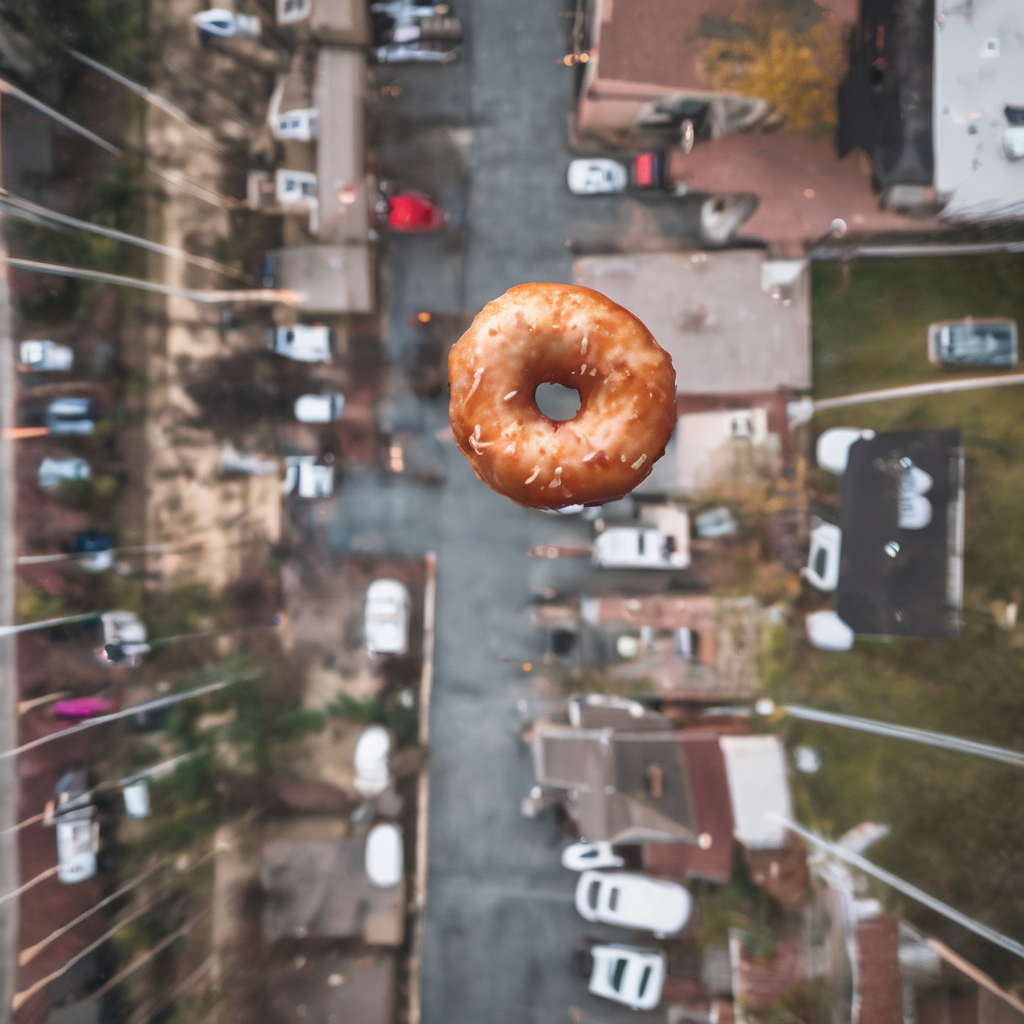

In [14]:
out.images[0]

In [15]:
results_detection = detector.detect(out.images[0], "primitive", device, 0.2, 0.4)

In [16]:
results_detection

[('donut', [0.436, 0.273, 0.228, 0.227]),
 ('neighborhood', [0.008, 0.003, 0.99, 0.985])]

In [17]:
width, height = out.images[0].size

In [18]:
from PIL import ImageDraw, ImageFont

In [19]:
img = out.images[0].copy()
draw = ImageDraw.Draw(img)
for (name, box) in results_detection:
    x1, y1, w, h = box
    x2 = x1 + w
    y2 = y1 + h
    x1 *= width
    x2 *= width
    y1 *= height
    y2 *= height
    draw.rectangle(((int(x1), int(y1)), (int(x2), int(y2))), outline=(255, 0, 0))
    font = ImageFont.load_default(size=20)
    text_size = draw.textbbox((0, 0), name, font=font)
    text_position = (x1, max(y1 - text_size[3] - 2, 0))
    draw.text(text_position, name, fill='black', font=font)


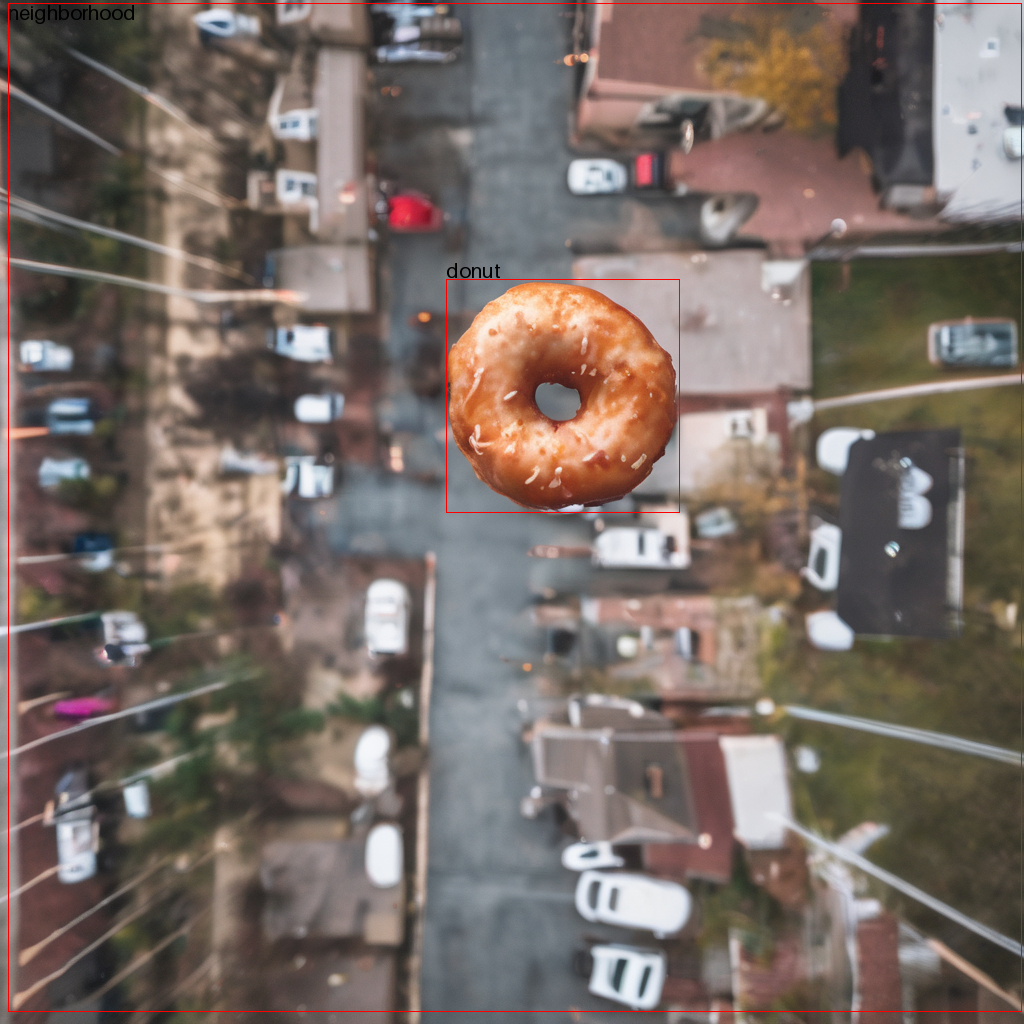

In [20]:
img